In [1]:
%load_ext autoreload

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # NOTSET, DEBUG, INFO, WARN, ERROR, CRITICAL

from JPAS_DA import global_setup
from JPAS_DA.data import loading_tools

import numpy as np

from JPAS_DA.utils import plotting_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')
plt.close('all')
font, rcnew = plotting_utils.matplotlib_default_config()
mpl.rc('font', **font)
plt.rcParams.update(rcnew)
plt.style.use('tableau-colorblind10')
%matplotlib widget

In [2]:
root_path = global_setup.DATA_path
load_JPAS_x_DESI_Raul   = global_setup.load_JPAS_x_DESI_Raul
load_DESI_mocks_Raul    = global_setup.load_DESI_mocks_Raul
load_Ignasi             = global_setup.load_Ignasi

random_seed_load = global_setup.default_seed

In [3]:
DATA = loading_tools.load_data_bundle(
    root_path=root_path,
    include=["JPAS_x_DESI_Raul", "DESI_mocks_Raul", "Ignasi"],
    JPAS_x_DESI_Raul={"datasets": load_JPAS_x_DESI_Raul},
    DESI_mocks_Raul={"datasets": load_DESI_mocks_Raul},
    Ignasi={"datasets": load_Ignasi},
    random_seed=random_seed_load,
)

2025-09-17 14:13:03,849 - INFO - 📥 Starting modular dataset loading (load_data_bundle)
2025-09-17 14:13:03,849 - INFO - ├── Loading JPAS_x_DESI_Raul ...
2025-09-17 14:13:03,849 - INFO - ├─── 📥 Starting JPAS_x_DESI_Raul dataset loading...
2025-09-17 14:13:03,849 - INFO - |    ├─── 🔹 Dataset: all (sample 100%)
2025-09-17 14:13:03,897 - INFO - |    |    ✔ CSV loaded: JPAS_DATA_PROPERTIES.csv (shape: (52020, 18))
2025-09-17 14:13:03,909 - INFO - |    |    ✔ NPY loaded: JPAS_DATA_Aper_Cor_3_FLUX+NOISE.npy (obs shape: (52020, 57))
2025-09-17 14:13:03,909 - WARNING - |    |    ⚠ No pickle file provided or file does not exist: /home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/DATA/JPAS_DATA_PROPERTIES_AUX.pkl
2025-09-17 14:13:03,909 - INFO - ├─── ✅ Finished loading all JPAS datasets.
2025-09-17 14:13:03,911 - INFO - │   ✔ Loaded JPAS_x_DESI_Raul
2025-09-17 14:13:03,911 - INFO - ├── Loading DESI_mocks_Raul ...
2025-09-17 14:13:03,911 - INFO - ├─── 📥 Loading DESI 

ratios: [0.71249519 0.05092272 0.23658208]
class_weights: [0.16663598 2.33151985 0.50184416]
ratios: [0.66737445 0.05467311 0.27795244]
class_weights: [0.19221321 2.34627551 0.46151128]
ratios: [0.94805323 0.03336161 0.00444358 0.01414158]
class_weights: [0.0129111  0.36690106 2.75462602 0.86556181]


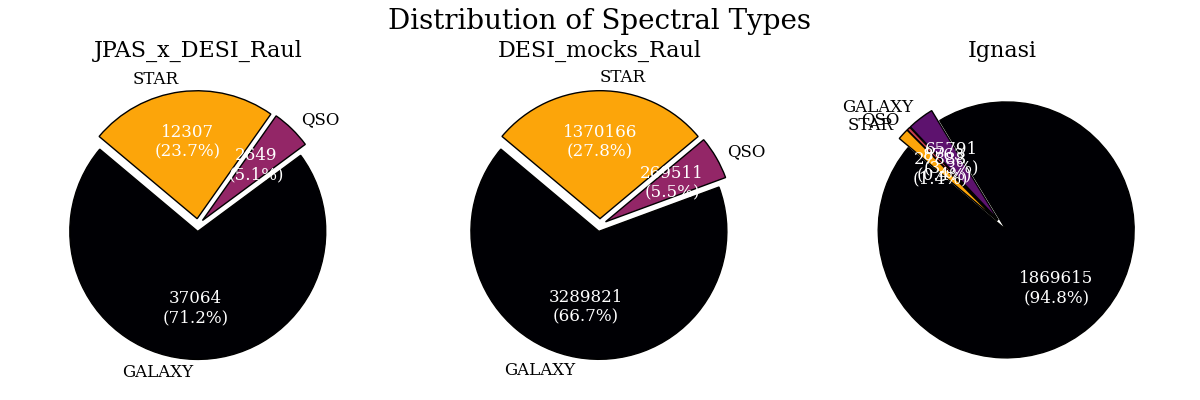

In [4]:
list_datasets = DATA.keys()

fig, axs = plt.subplots(1, len(list_datasets), figsize=(4*len(list_datasets), 4))

for ii, survey_key in enumerate(list_datasets):

    unique_spectype_names, counts = np.unique(DATA[survey_key]["all_pd"]['SPECTYPE'], return_counts=True)

    ratios = counts / np.sum(counts)
    print("ratios:", ratios)
    inverse_ratios = 1.0 / ratios
    class_weights = inverse_ratios / inverse_ratios.mean()
    print("class_weights:", class_weights)

    ax = axs[ii]
    colors = plt.cm.inferno(np.linspace(0., 0.8, len(counts)))
    explode = [0.05] * len(counts)

    # Function to display count and percentage in two lines
    def make_autopct(counts):
        def my_autopct(pct):
            total = sum(counts)
            absolute = int(round(pct * total / 100.0))
            return f"{absolute}\n({pct:.1f}%)"
        return my_autopct

    # Create pie chart
    wedges, texts, autotexts = ax.pie(
        counts,
        labels=unique_spectype_names,
        autopct=make_autopct(counts),
        startangle=140,
        colors=colors,
        explode=explode,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1},
        textprops={'fontsize': 12}
    )

    # Customize font color inside pie
    for autotext in autotexts:
        autotext.set_color("white")

    ax.set_title(f"{survey_key}", fontsize=16)

# General title
plt.suptitle("Distribution of Spectral Types", fontsize=20)
plt.tight_layout()
plt.show()

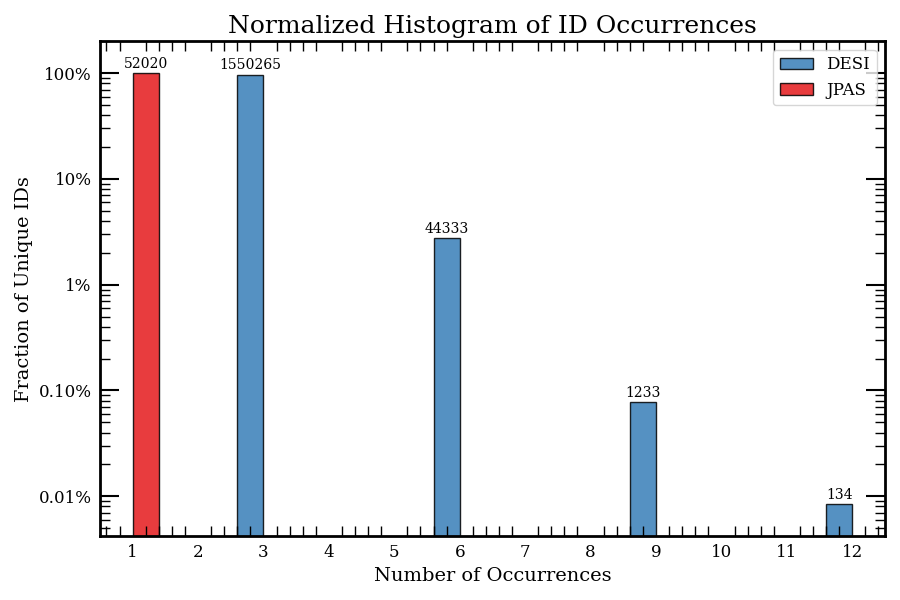

In [5]:
# === Compute DESI histogram ===
_, desi_counts = np.unique(DATA["DESI_mocks_Raul"]["all_pd"]['TARGETID'], return_counts=True)
unique_desi, count_desi = np.unique(desi_counts, return_counts=True)

# === Compute JPAS histogram ===
_, jpas_counts = np.unique(DATA["JPAS_x_DESI_Raul"]["all_pd"]['TARGETID'], return_counts=True)
unique_jpas, count_jpas = np.unique(jpas_counts, return_counts=True)

# === Unified occurrence axis ===
occurrences = np.union1d(unique_desi, unique_jpas).astype(int)  # sorted
occ_min, occ_max = int(occurrences.min()), int(occurrences.max())
ticks_natural = np.arange(max(1, occ_min), occ_max + 1)  # every integer, no skips

# Bar centers are the actual occurrence counts (1,2,3,...)
x = occurrences.astype(float)  # float for +/- bar_width shifts

# === Align frequencies ===
aligned_desi = np.array([count_desi[unique_desi.tolist().index(v)] if v in unique_desi else 0 for v in occurrences])
aligned_jpas = np.array([count_jpas[unique_jpas.tolist().index(v)] if v in unique_jpas else 0 for v in occurrences])

# === Normalize ===
frac_desi = aligned_desi / aligned_desi.sum()
frac_jpas = aligned_jpas / aligned_jpas.sum()

# pick safe ymin for log scale (skip zeros)
pos = np.concatenate([frac_desi[frac_desi > 0], frac_jpas[frac_jpas > 0]])
ymin = max((pos.min() * 0.5) if pos.size else 1e-6, 1e-6)

# === Plot ===
fig, ax = plt.subplots(figsize=(9, 6))
bar_width = 0.4

ax.bar(x - bar_width/2, frac_desi, width=bar_width, color="#377eb8", label="DESI", edgecolor="black", alpha=0.85)
ax.bar(x + bar_width/2, frac_jpas, width=bar_width, color="#e41a1c", label="JPAS", edgecolor="black", alpha=0.85)

# === SAFE annotations: skip zeros
for xi, fd, fj, ad, aj in zip(x, frac_desi, frac_jpas, aligned_desi, aligned_jpas):
    if ad > 0 and fd > 0:
        ax.text(xi - bar_width/2, fd*1.05, str(ad), ha='center', va='bottom', fontsize=10, clip_on=True)
    if aj > 0 and fj > 0:
        ax.text(xi + bar_width/2, fj*1.05, str(aj), ha='center', va='bottom', fontsize=10, clip_on=True)

# === Axis labels and style ===
ax.set_title("Normalized Histogram of ID Occurrences", fontsize=18)
ax.set_xlabel("Number of Occurrences", fontsize=14)
ax.set_ylabel("Fraction of Unique IDs", fontsize=14)
ax.set_yscale("log")
ax.set_ylim(bottom=ymin, top=2.0)

# Force natural-number x-axis without skips
ax.set_xticks(ticks_natural)
ax.set_xlim(ticks_natural[0] - 0.5, ticks_natural[-1] + 0.5)
ax.set_xticklabels(ticks_natural, fontsize=12)
ax.tick_params(axis='x', length=0)

ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: f"{y:.0%}" if y >= 0.01 else f"{y:.2%}"))
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12, frameon=True, loc='upper right')

plt.tight_layout()
plt.show()